In [3]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
from ipynb.fs.full.All_Functions import GetPopParams
from ipynb.fs.full.All_Functions import GetPopParamsOmega
from ipynb.fs.full.All_Functions import GetVLIndParams
from ipynb.fs.full.All_Functions import RandVLIndParams
from ipynb.fs.full.All_Functions import RandVLParams
from ipynb.fs.full.All_Functions import PKPDParams
from ipynb.fs.full.All_Functions import Cohort_Prep
from ipynb.fs.full.All_Functions import VLModel
from ipynb.fs.full.All_Functions import VLPKPD
from ipynb.fs.full.All_Functions import PK_Model
from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
from ipynb.fs.full.All_Functions import SimulateTreatment
from ipynb.fs.full.All_Functions import Trial_Simulation
from ipynb.fs.full.All_Functions import Trial_Simulation_paramInput
from ipynb.fs.full.All_Functions import SimulateTreatmentPK
from ipynb.fs.full.All_Functions import TreatmentImpact
from ipynb.fs.full.All_Functions import CI_Calc
from ipynb.fs.full.All_Functions import ParamsPrep
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings("ignore")

589
528


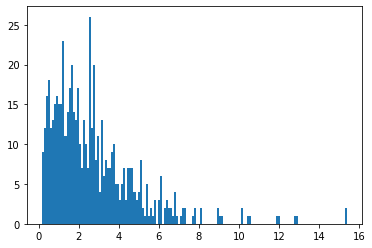

291
237
18
510


In [5]:
##  --- Within-host parameters


parameters_file =  r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Monolix/Projects/E0_I0_Vest_logitt0_SympOnsetKnown_AppendNegatives/IndividualParameters/estimatedIndividualParameters.txt'
Popparameters_file =  r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Monolix/Projects/E0_I0_Vest_logitt0_SympOnsetKnown_AppendNegatives/populationParameters.txt'
data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBA_SymptomOnsetKnown.csv'

# load parameters into data frame
parameters_df = pd.read_csv(parameters_file)
#print(parameters_df.id)
Popparameters_df = pd.read_csv(Popparameters_file)
#print(parameters_df)
# load data into data frame
data_df = pd.read_csv(data_file)
IDsTot_param = parameters_df.id
print(len(IDsTot_param))
IDsTot = data_df.ID.unique()
print(len(IDsTot))
# ------------- Stratifying Based on PeakVL----------------------
m = []

tzero= parameters_df['tzero_mode']
#print(np.min(tzero))
    #finding the mode
n, bins, patches = plt.hist(tzero.values, bins = 150)
#plt.xlim([0.0067, 0.0075])
plt.show()

#---------------------- Stratifying based on age -----------------------------
OLDPop = data_df[data_df.cat_AgeGroup != 1]
YounPop = data_df[data_df.cat_AgeGroup == 1]
IDOld = OLDPop.ID.unique()
IDYoung = YounPop.ID.unique()
print(len(IDOld))
print(len(IDYoung))
# ------------------------ Stratifying based on Duration -----------------------------
LongShedPop = data_df[data_df.Duration >14]
ShortShedPop = data_df[data_df.Duration <=14]
IDLongShed = LongShedPop.ID.unique()
IDShortShed = ShortShedPop.ID.unique()
print(len(IDLongShed))
print(len(IDShortShed))
# -------------- Combining Filters ----------------------------------------


## --------------------- PK parameters -----------------------------
Indparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRestimatedIndividualParameters.txt'
Popparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRpopulationParameters(2).txt'
Indparameters_PK = pd.read_csv(Indparameters_U_file)
Popparameters_PK = pd.read_csv(Popparameters_U_file)

IDs_U = Indparameters_PK.id.unique()

In [11]:
def StandardDoseTimeSim(TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    X = []
    times = []
    for idi, tstart, in enumerate(TrtmntStrtDay):
        t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                      PKPDInd[idi], param_dict[idi], 
                                                      PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X.append(np.log10(np.maximum(V,10**2)))
        X[idi][X[idi]==2]=1
        times.append(t)
    return X, times

In [12]:
def ParamsPrep(Cohort, CohortStyle, GetVLIndParams, RandVLParams, parameters_df, Popparameters_df, fixed_params, param_order, param_dist,
               PKPDParams, Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill,PDOm, dose):

    VLparams = []
    PKPD_params = []
    param_dict = []
    for ID in Cohort:
        if CohortStyle == 'direct':
            ind_params = GetVLIndParams(parameters_df, ID, style = 'mode')
        else:
            ind_params = RandVLParams(Popparameters_df, param_dist)
            
        _dict = {**fixed_params, **ind_params}
        param_dict.append(_dict)
        params = []
        for k in param_order:
            params.append(_dict[k])
        VLparams.append(params)
        pkpd =PKPDParams(Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill, dose, PDOm)
        PKPD_params.append(pkpd)
    return VLparams, PKPD_params, param_dict

In [13]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta','h', 'm', 'pi', 'c', 'tAI']
fixed_params = dict({'c': 15, 'r':10, 'k':4})
param_dist = dict({'V0':'logitNormal', 'V0min': 0, 'V0max': 250, 'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tAI': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':30})

In [14]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['V0']
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0]

In [15]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol
dose =300

## Measuring rebound on day 5 after treatment ends

In [20]:
# prepare cohort parameters
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
PotRed = 61
MolMass = 499.5 
Num = 500
Cohort = Cohort_Prep(IDsTot_param, Num)
CohortStyle = 'direct'

for tr in range(0,10):
    print(tr)
    dose = 0
    VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                                   RandVLParams, parameters_df, Popparameters_df, 
                                                   fixed_params, param_order, param_dist, PKPDParams, 
                                                   Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                                   Emax, IC50, Hill,PDOm, dose)
    V_all_timing = []
    t_all_timing = []
    TrtmntStrtDay_all_timing=[]

    V_Cntrl_all_timing = []
    t_Cntrl_all_timing = []
    TrtmntStrtDay_Cntrl_all_timing=[]
    # ---------------------------- simulate without treament ----------------------------------
    for timing in ['PEP', 'Early Trtmnt', 'Trial', 'Late Trtmnt']: 
        print("  " + str(timing))
        Cohort = Cohort_Prep(IDsTot_param, Num)
        #print(TrtmntStrtDay)
        if timing == 'PEP':
            TrtmntStrtDay = [random.randint(0, 1) for i in range(0,len(Cohort))]
            for idi in range(0, Num):
                if (TrtmntStrtDay[idi]-param_dict[idi]['tzero']>0):
                    TrtmntStrtDay [idi] =  -param_dict[idi]['tzero']
                else:
                    TrtmntStrtDay [idi] =TrtmntStrtDay[idi]-param_dict[idi]['tzero']
        elif timing == 'Early Trtmnt':
            TrtmntStrtDay = [random.randint(0, 1) for i in range(0,len(Cohort))]
        elif timing =='Trial':
            TrtmntStrtDay = [random.randint(1, 5) for i in range(0,len(Cohort))]
        else:
            TrtmntStrtDay = [random.randint(5, 10) for i in range(0,len(Cohort))]

        TrtmntStrtDay_Cntrl_all_timing.append(TrtmntStrtDay)

        dose = 0
        X, times = StandardDoseTimeSim(TrtmntStrtDay, VLparams, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 1)
        V_Cntrl_all_timing.append(X)
        t_Cntrl_all_timing.append(times)

    #  --------------------------------------- simulate with treatment ----------------------------------
    for timing in ['PEP', 'Early Trtmnt', 'Trial', 'Late Trtmnt']: 
        dose = 300
        print(timing)
        Cohort = Cohort_Prep(IDsTot_param, Num)
        VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                                   RandVLParams, parameters_df, Popparameters_df, 
                                                   fixed_params, param_order, param_dist, PKPDParams, 
                                                   Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                                   Emax, IC50, Hill,PDOm, dose)
        if timing == 'PEP':
            TrtmntStrtDay = [random.randint(0, 1) for i in range(0,len(Cohort))]
            for idi in range(0, Num):
                if (TrtmntStrtDay[idi]-param_dict[idi]['tzero']>0):
                    TrtmntStrtDay [idi] =  -param_dict[idi]['tzero']
                else:
                    TrtmntStrtDay [idi] =TrtmntStrtDay[idi]-param_dict[idi]['tzero']
        elif timing == 'Early Trtmnt':
            TrtmntStrtDay = [random.randint(0, 1) for i in range(0,len(Cohort))]
        elif timing =='Trial':
            TrtmntStrtDay = [random.randint(1, 5) for i in range(0,len(Cohort))]
        else:
            TrtmntStrtDay = [random.randint(5, 10) for i in range(0,len(Cohort))]

        X, times = StandardDoseTimeSim(TrtmntStrtDay, VLparams, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
        V_all_timing.append(X)
        t_all_timing.append(times)
        TrtmntStrtDay_all_timing.append(TrtmntStrtDay)

        # ------------------------------------ calculating rebound probability ----------------
    dur = 5
    rebound2 = []
    rebound1 = []
    rebound05 = []
    df_tot = []
    for i, (timing ,X ,times) in enumerate(zip(['PEP', 'Early', 'Intermediate', 'Late'], V_all_timing,t_all_timing)):
        L1 = np.zeros(len(X))
        L1_control = np.zeros(len(X))
        for ii,(x,t) in enumerate(zip(X,times)):
        # -- flag if treament VL ever exceeds NH VL
        # need to modify simulation function to unify the timesteps at 
        # which we report values
        # -- flag rebound if increase of viral load by at least 2 log following end of treatment
            temp = np.argwhere(t>TrtmntStrtDay_all_timing[i][ii]+dur)
            idx = temp[0][0]
            idx_five = np.argwhere(t>TrtmntStrtDay_all_timing[i][ii]+dur+5)[0][0]
            argmax = np.argmax(V_Cntrl_all_timing[i][ii])
            peaks2, props2 = find_peaks(V_Cntrl_all_timing[i][ii], height = 3, prominence = 2)
            peaks1, props1 = find_peaks(V_Cntrl_all_timing[i][ii], height = 3, prominence = 1)
            peaks05, props05 = find_peaks(V_Cntrl_all_timing[i][ii], height = 3, prominence = 0.5)
            if (x[idx_five]-x[idx])>2:
                L1[ii] = 1
                rebound2.append({'arm': 'Treatment', 'Timing of Therapy':timing, 'rebound': 'Yes'})
            else:
                rebound2.append({'arm': 'Treatment','Timing of Therapy':timing, 'rebound': 'No'})
            
            if (x[idx_five]-x[idx])>1:
                rebound1.append({'arm': 'Treatment', 'Timing of Therapy':timing, 'rebound': 'Yes'})
            else:
                rebound1.append({'arm': 'Treatment','Timing of Therapy':timing, 'rebound': 'No'})
            
            if (x[idx_five]-x[idx])>0.5:
                rebound05.append({'arm': 'Treatment', 'Timing of Therapy':timing, 'rebound': 'Yes'})
            else:
                rebound05.append({'arm': 'Treatment','Timing of Therapy':timing, 'rebound': 'No'})

            if (len(peaks2)>1):
                rebound2.append({'arm': 'Control','Timing of Therapy':timing, 'rebound': 'Yes'})
            else:
                rebound2.append({'arm': 'Control','Timing of Therapy':timing, 'rebound': 'No'})
            
            if (len(peaks1)>1):
                rebound1.append({'arm': 'Control','Timing of Therapy':timing, 'rebound': 'Yes'})
            else:
                rebound1.append({'arm': 'Control','Timing of Therapy':timing, 'rebound': 'No'})
                
            if (len(peaks05)>1):
                rebound05.append({'arm': 'Control','Timing of Therapy':timing, 'rebound': 'Yes'})
            else:
                rebound05.append({'arm': 'Control','Timing of Therapy':timing, 'rebound': ' No'})
    rebound2 = pd.DataFrame(rebound2)
    rebound1 = pd.DataFrame(rebound1)
    rebound05 = pd.DataFrame(rebound05)
    x,y = 'Timing of Therapy', 'rebound'

    df2 = rebound2.groupby(['arm',x])[y].value_counts(normalize=True)
    df2 = df2.mul(100)
    df2 = df2.rename('% rebound').reset_index()
    
    if tr == 0:
        df_timing_2 = df2.copy()
    else:
        df_timing_2 = pd.concat([df_timing_2, df2])
        
    df1 = rebound1.groupby(['arm',x])[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('% rebound').reset_index()
    
    if tr == 0:
        df_timing_1 = df1.copy()
    else:
        df_timing_1 = pd.concat([df_timing_1, df1])
        
    df05 = rebound05.groupby(['arm',x])[y].value_counts(normalize=True)
    df05 = df05.mul(100)
    df05 = df05.rename('% rebound').reset_index()
    
    if tr == 0:
        df_timing_05 = df05.copy()
    else:
        df_timing_05 = pd.concat([df_timing_05, df05])

0
  PEP
  Early Trtmnt
  Trial
  Late Trtmnt
PEP
Early Trtmnt
Trial
Late Trtmnt
1
  PEP
  Early Trtmnt
  Trial
  Late Trtmnt
PEP
Early Trtmnt
Trial
Late Trtmnt
2
  PEP
  Early Trtmnt
  Trial
  Late Trtmnt
PEP
Early Trtmnt
Trial
Late Trtmnt
3
  PEP
  Early Trtmnt
  Trial
  Late Trtmnt
PEP
Early Trtmnt
Trial
Late Trtmnt
4
  PEP
  Early Trtmnt
  Trial
  Late Trtmnt
PEP
Early Trtmnt
Trial
Late Trtmnt
5
  PEP
  Early Trtmnt
  Trial
  Late Trtmnt
PEP
Early Trtmnt
Trial
Late Trtmnt
6
  PEP
  Early Trtmnt
  Trial
  Late Trtmnt
PEP
Early Trtmnt
Trial
Late Trtmnt
7
  PEP
  Early Trtmnt
  Trial
  Late Trtmnt
PEP
Early Trtmnt
Trial
Late Trtmnt
8
  PEP
  Early Trtmnt
  Trial
  Late Trtmnt
PEP
Early Trtmnt
Trial
Late Trtmnt
9
  PEP
  Early Trtmnt
  Trial
  Late Trtmnt
PEP
Early Trtmnt
Trial
Late Trtmnt


(0.0, 80.0)

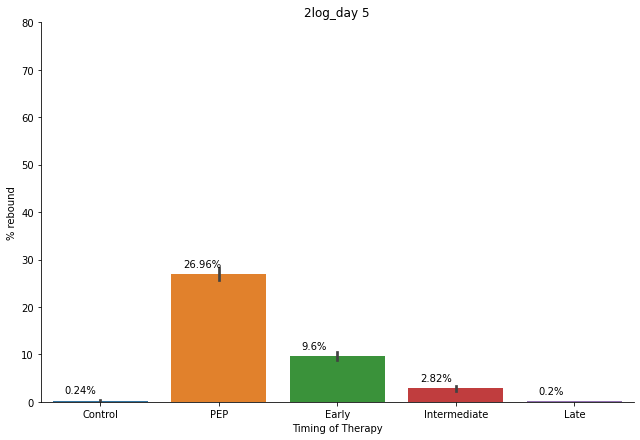

In [21]:
df_timing_2_cntrl=df_timing_2[(df_timing_2.arm=='Control')*(df_timing_2.rebound == 'Yes')]
df_timing_2_others=df_timing_2[(df_timing_2.arm!='Control')*(df_timing_2.rebound == 'Yes')]
df_timing_2_Yes = pd.concat([df_timing_2_cntrl,df_timing_2_others])
rebound_timing_Control = df_timing_2_Yes[(df_timing_2_Yes.arm=='Control')*(df_timing_2_Yes['Timing of Therapy'] == 'PEP')]
rebound_timing_Control['Timing of Therapy'] = 'Control'
rebound_timing_2 = pd.concat([rebound_timing_Control, df_timing_2_others])
g = sns.catplot(x='Timing of Therapy',y='% rebound', kind='bar',data=rebound_timing_2, height=6, aspect=1.5, ci = 95,
               order = ['Control','PEP', 'Early', 'Intermediate', 'Late'])
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()+0.1
    txt_y = p.get_height()+1.5
    g.ax.text(txt_x,txt_y,txt, size = 'medium')
plt.title('2log_day 5')
g.ax.set_ylim([0, 80])


(0.0, 80.0)

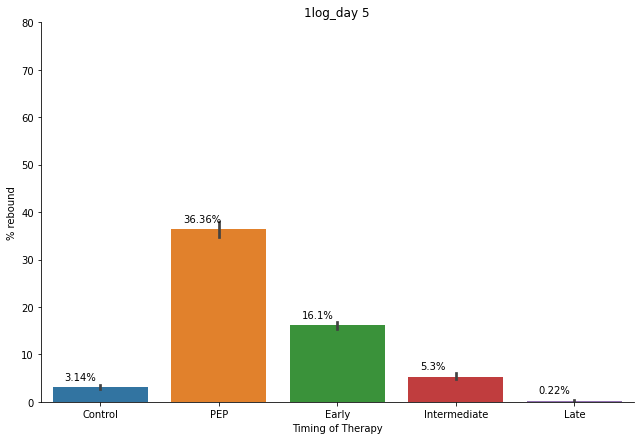

In [22]:
df_timing_1_cntrl=df_timing_1[(df_timing_1.arm=='Control')*(df_timing_1.rebound == 'Yes')]
df_timing_1_others=df_timing_1[(df_timing_1.arm!='Control')*(df_timing_1.rebound == 'Yes')]
df_timing_1_Yes = pd.concat([df_timing_1_cntrl,df_timing_1_others])
rebound_timing_Control = df_timing_1_Yes[(df_timing_1_Yes.arm=='Control')*(df_timing_1_Yes['Timing of Therapy'] == 'PEP')]
rebound_timing_Control['Timing of Therapy'] = 'Control'
rebound_timing_1 = pd.concat([rebound_timing_Control, df_timing_1_others])
g = sns.catplot(x='Timing of Therapy',y='% rebound', kind='bar',data=rebound_timing_1, height=6, aspect=1.5, ci = 95,
               order = ['Control','PEP', 'Early', 'Intermediate', 'Late'])
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()+0.1
    txt_y = p.get_height()+1.5
    g.ax.text(txt_x,txt_y,txt, size = 'medium')
plt.title('1log_day 5')
g.ax.set_ylim([0, 80])


(0.0, 80.0)

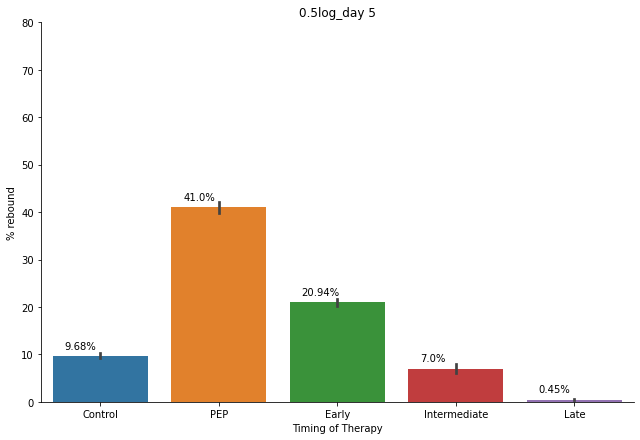

In [23]:
df_timing_05_cntrl=df_timing_05[(df_timing_05.arm=='Control')*(df_timing_05.rebound == 'Yes')]
df_timing_05_others=df_timing_05[(df_timing_05.arm!='Control')*(df_timing_05.rebound == 'Yes')]
df_timing_05_Yes = pd.concat([df_timing_05_cntrl,df_timing_05_others])
rebound_timing_Control = df_timing_05_Yes[(df_timing_05_Yes.arm=='Control')*(df_timing_05_Yes['Timing of Therapy'] == 'PEP')]
rebound_timing_Control['Timing of Therapy'] = 'Control'
rebound_timing_05 = pd.concat([rebound_timing_Control, df_timing_05_others])
g = sns.catplot(x='Timing of Therapy',y='% rebound', kind='bar',data=rebound_timing_05, height=6, aspect=1.5, ci = 95,
               order = ['Control','PEP', 'Early', 'Intermediate', 'Late'])
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()+0.1
    txt_y = p.get_height()+1.5
    g.ax.text(txt_x,txt_y,txt, size = 'medium')
plt.title('0.5log_day 5')
g.ax.set_ylim([0, 80])
